In [19]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("white")

In [20]:
prefix = "HH_object_BITP_"
filename = "object_id_bitp_new_filtered_combined.txt"
s = open(filename, "r").readlines()    

In [21]:
raw_pr = []
raw_mem = []
raw_time = []
raw_final_mem = []
ln = 0
query_type = ""
flagFinal = False
for line in s:
    if line.startswith("START_OF_FINAL_STATS_REPORT"):
        flagFinal = True
    if line.startswith("Stats request at line"):
        ln = int(re.findall("\d+", line)[1])
        flagFinal = False
    if line.find(" timers") != -1:
        query_type = line.strip().split(" ")[0]
    if line.find(" ms = ") != -1:
        t = line.strip().split(':')
        if t[0] != "EXACT_HH":
            sketch = t[0].split('-')
            sketch = [sketch[0], ''.join(sketch[1:])]
            raw_time.append(sketch + [ln, query_type, int(t[1].split("=")[1].strip()[:-3])])
    if line.find("prec") != -1:
        t = line.strip().split(':')
        if t[0] != "EXACT_HH":
            sketch = t[0].split('-')
            sketch = [sketch[0], ''.join(sketch[1:])]
            pr_info = t[1].split(",")
            try:
                pr_info = list(map(lambda x: float(x.split('=')[2].strip()), pr_info))
            except ZeroDivisionError:
                continue
            raw_pr.append(sketch + [pr_info[0], pr_info[1]])
    if line.find("MB") != -1:
        t = line.strip().split(':')
        if t[0] != "EXACT_HH":
            sketch = t[0].split('-')
            s_param = ''.join(sketch[1:])
            if sketch[0] == "SAMPLING_BITP":
                if s_param.endswith("_max"):
                    s_param = s_param[:-4]
                else:
                    continue
            t = [sketch[0], s_param, ln, int(t[1].split("=")[0].strip()[:-2])]            
            if flagFinal:
                raw_final_mem.append(t)
            else:
                raw_mem.append(t)

In [22]:
mem = pd.DataFrame(raw_mem, columns = ["Sketch", "Param", "Stream Size", "Memory Usage (B)"])
mem

,Sketch,Param,Stream Size,Memory Usage (B)
0,TMG_BITP,e0.000200,13528041,636074640
1,SAMPLING_BITP,ss10000use_new_impl2,13528041,10885056
2,TMG_BITP,e0.000200,27056082,925677192
3,SAMPLING_BITP,ss10000use_new_impl2,27056082,11525056
4,TMG_BITP,e0.000200,40584123,1202242960
...,...,...,...,...
2395,TMG_BITP,e0.004000,1339276059,157817176
2396,SAMPLING_BITP,ss500000use_new_impl2,1339276059,672005056
2397,TMG_BITP,e0.004000,1352804100,147111768
2398,SAMPLING_BITP,ss500000use_new_impl2,1352804100,704005056


In [23]:
time = pd.DataFrame(raw_time, columns = ["Sketch", "Param", "Stream Size", "Type", "Time (ms)"])
time_processed = pd.merge(time, mem, on = ["Sketch", "Param", "Stream Size"]).drop_duplicates()
utime = time_processed[time_processed["Type"] == "Update"]
utime

,Sketch,Param,Stream Size,Type,Time (ms),Memory Usage (B)
0,TMG_BITP,e0.000200,13528041,Update,9813,636074640
2,SAMPLING_BITP,ss10000use_new_impl2,13528041,Update,4504,10885056
4,TMG_BITP,e0.000200,27056082,Update,20679,925677192
6,SAMPLING_BITP,ss10000use_new_impl2,27056082,Update,10016,11525056
8,TMG_BITP,e0.000200,40584123,Update,31177,1202242960
...,...,...,...,...,...,...
4850,TMG_BITP,e0.004000,1339276059,Update,521628,157817176
4852,SAMPLING_BITP,ss500000use_new_impl2,1339276059,Update,573787,672005056
4854,TMG_BITP,e0.004000,1352804100,Update,534538,147111768
4855,TMG_BITP,e0.004000,1352804100,Update,534538,147111848


In [24]:
pr = pd.DataFrame(raw_pr, columns = ["Sketch", "Param", "Precision", "Recall"])
final_mem = final_mem = pd.DataFrame(raw_final_mem, columns = ["Sketch", "Param", "Stream Size", "Memory Usage (B)"])
pr = pd.merge(pr, final_mem, on = ["Sketch", "Param"]).groupby(["Sketch", "Param", "Memory Usage (B)"]).mean().drop("Stream Size", 1)
pr = pd.DataFrame(pr.to_records())
pr

,Sketch,Param,Memory Usage (B),Precision,Recall
0,PCM_HH,logU17e0.0005d0.01D2000,236404732,0.572064,1.000000
1,PCM_HH,logU17e0.001d0.01D2000,201638580,0.642857,1.000000
2,SAMPLING_BITP,ss1000000use_new_impl2,1344005056,1.000000,1.000000
3,SAMPLING_BITP,ss100000use_new_impl2,140805056,0.950000,0.933333
4,SAMPLING_BITP,ss10000use_new_impl2,14085056,0.916667,0.850000
5,SAMPLING_BITP,ss250000use_new_impl2,352005056,0.950000,1.000000
6,SAMPLING_BITP,ss25000use_new_impl2,35205056,0.960000,0.966667
7,SAMPLING_BITP,ss500000use_new_impl2,704005056,1.000000,1.000000
8,SAMPLING_BITP,ss50000use_new_impl2,70405056,0.910000,0.900000
9,SAMPLING_BITP,ss750000use_new_impl2,1056005056,1.000000,1.000000


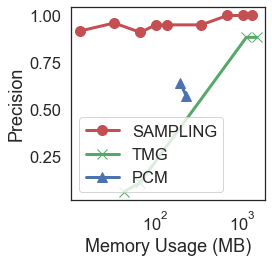

In [25]:
fig, ax = plt.subplots(figsize = (4, 4))
sketch_type = ["SAMPLING_BITP", "TMG_BITP", "PCM_HH"]
sketch_param = {
    "PCM_HH" : ["logU17e0.0005d0.01D2000", "logU17e0.001d0.01D2000"],
    "SAMPLING_BITP" : ["ss1000000use_new_impl2", "ss75000use_new_impl2"],
    "TMG_BITP" : ["e0.001000", "e0.0080000"],
}
        
linestyles = ["-", "--", "."]
colors = ["r", "g", "b"]
markers = ["o", "x", "^"]
ms = 10
lw = 3

cnt = 0
for sk in sketch_type:
    dat = pr[pr["Sketch"] == sk].sort_values(by = "Memory Usage (B)").transpose().to_numpy()
    plt.plot(dat[2] / 1048576.0, dat[3], color = colors[cnt], marker = markers[cnt], label = sk.split("_")[0], markersize = ms, linewidth = lw)
    cnt += 1
ax.legend()
ax.set_xscale("log")
ax.set_xlabel("Memory Usage (MB)")
ax.set_ylabel("Precision")
plt.tight_layout()
plt.savefig(prefix + 'precision.pdf')

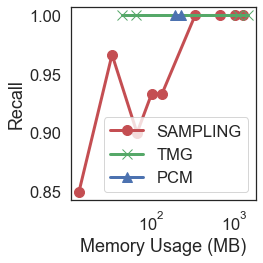

In [26]:
fig, ax = plt.subplots(figsize = (4, 4))
cnt = 0
for sk in sketch_type:
    dat = pr[pr["Sketch"] == sk].sort_values(by = "Memory Usage (B)").transpose().to_numpy()
    plt.plot(dat[2] / 1048576.0, dat[4], color = colors[cnt], marker = markers[cnt], label = sk.split("_")[0], markersize = ms, linewidth = lw)
    cnt += 1
ax.legend()

ax.set_xscale("log")
ax.set_xlabel("Memory Usage (MB)")
ax.set_ylabel("Recall")
plt.tight_layout()
plt.savefig(prefix + 'recall.pdf')

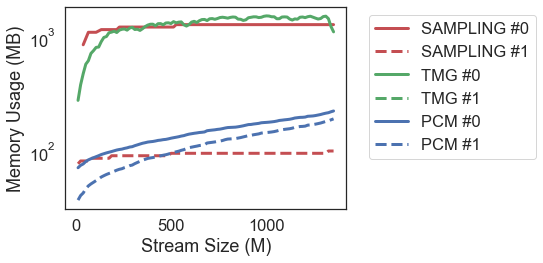

In [27]:
fig, ax = plt.subplots(figsize = (8, 4))
cnt = 0

for sk in sketch_type:
    cnt0 = 0
    for p in sketch_param[sk]:
        dat = mem[(mem["Sketch"] == sk) & (mem["Param"] == p)].sort_values(by = "Stream Size").transpose().to_numpy()
        plt.plot(dat[2] / 1000000.0, dat[3] / 1048576.0, label = "%s #%d" % (sk.split("_")[0], cnt0), markersize = ms, color = colors[cnt], linestyle = linestyles[cnt0], linewidth = lw)
        cnt0 += 1
    cnt += 1

ax.legend(bbox_to_anchor=(1.05, 1))

ax.set_yscale("log")
ax.set_xlabel("Stream Size (M)")
ax.set_ylabel("Memory Usage (MB)")
plt.tight_layout()
plt.savefig(prefix + 'mem.pdf')

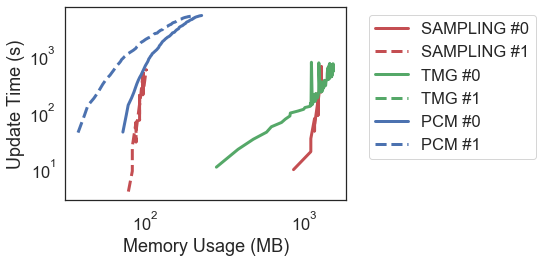

In [28]:
fig, ax = plt.subplots(figsize = (8, 4))
cnt = 0
for sk in sketch_type:
    cnt0 = 0
    for p in sketch_param[sk]:
        dat = utime[(utime["Sketch"] == sk) & (utime["Param"] == p)].sort_values(by = "Memory Usage (B)").transpose().to_numpy()
        plt.plot(dat[-1] / 1048576.0, dat[-2] / 1000.0, label = "%s #%d" % (sk.split("_")[0], cnt0), markersize = ms, color = colors[cnt], linestyle = linestyles[cnt0], linewidth = lw)
        cnt0 += 1
    cnt += 1

ax.legend(bbox_to_anchor=(1.05, 1))
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Memory Usage (MB)")
ax.set_ylabel("Update Time (s)")
plt.tight_layout()
plt.savefig(prefix + 'time.pdf')